In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
# torch.set_num_threds(2)

In [3]:
#export
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [4]:
#export
def get_data():
    mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter('training', 'testing'),
                 get_y = parent_label)
    dls = mnist.dataloaders(untar_data(URLs.MNIST))
    x_train, y_train = zip(*dls.train_ds)
    x_valid, y_valid = zip(*dls.valid_ds)

    x_train = tensor(list(map(array, x_train)), dtype=torch.float32).view(len(dls.train_ds), -1)
    x_valid = tensor(list(map(array, x_valid)), dtype=torch.float32).view(len(dls.valid_ds), -1)
    y_train = tensor(y_train)
    y_valid = tensor(y_valid)
    
    x_train, x_valid = x_train / 255.0, x_valid / 255.0
    x_train, x_valid = normalize_to(x_train, x_valid)

    return x_train, y_train, x_valid, y_valid

In [5]:
x_train, y_train, x_valid, y_valid = get_data()

In [6]:
x_train.mean(), x_train.std()

(tensor(-5.9790e-09), tensor(1.0000))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [8]:
x_train.shape[0]

60000

In [9]:
x_train.shape[0] / bs # number of batches for one epoch

117.1875

In [10]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [11]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [12]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)

In [13]:
def flatten(x): return x.view(x.shape[0], -1)
def mnist_view(x): return x.view(-1, 1, 28, 28)

In [14]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, stride, padding=ks//2), nn.ReLU())

In [15]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_view),
        conv2d(1, 8, 5), # 14
        conv2d(8, 16, 3), #7
        conv2d(16, 32, 3), #4
        conv2d(32, 32, 3), #2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [16]:
model = get_cnn_model(data)

In [17]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [18]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [19]:
%time run.fit(1, learn)

train: [1.8230669270833333, tensor(0.3652)]
valid: [0.51289072265625, tensor(0.8550)]
CPU times: user 22 s, sys: 731 ms, total: 22.7 s
Wall time: 5.67 s


In [20]:
device = torch.device('cuda', 0)

In [21]:
class CudaCallback(Callback):
    def __init__(self, device): self.device = device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [22]:
torch.cuda.set_device(device)

In [23]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [24]:
cbfs.append(CudaCallback)

In [25]:
model = get_cnn_model(data)

In [26]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [27]:
run.fit(3, learn)

train: [1.742919140625, tensor(0.3979, device='cuda:0')]
valid: [0.54331962890625, tensor(0.8215, device='cuda:0')]
train: [0.29783658854166667, tensor(0.9072, device='cuda:0')]
valid: [0.432213037109375, tensor(0.8629, device='cuda:0')]
train: [0.17688513997395833, tensor(0.9468, device='cuda:0')]
valid: [0.16654932861328126, tensor(0.9457, device='cuda:0')]


In [28]:
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

In [29]:
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [30]:
mnist_view = view_tfm(1,28,28)

In [31]:
xb = x_train[:bs]

In [32]:
mnist_view(xb).shape

torch.Size([512, 1, 28, 28])

In [33]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [34]:
nfs = [8, 16, 32, 32]

In [35]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], 5 if i == 0 else 3) for i in range(len(nfs) - 1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [36]:
def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

In [37]:
def get_learn_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    
    return learn, Runner(cb_funcs=listify(cbs))

In [38]:
model = get_cnn_model(data, nfs)
learn, run = get_learn_runner(model, data, lr=0.4, cbs=cbfs)

In [39]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [40]:
run.fit(3, learn)

train: [1.9169733072916666, tensor(0.3252, device='cuda:0')]
valid: [0.7509875, tensor(0.7265, device='cuda:0')]
train: [0.312254296875, tensor(0.9026, device='cuda:0')]
valid: [0.41173388671875, tensor(0.8699, device='cuda:0')]
train: [0.14991373697916666, tensor(0.9546, device='cuda:0')]
valid: [0.15995814208984374, tensor(0.9478, device='cuda:0')]


# Hooks

In [41]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean())
            self.act_stds[i].append(x.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [42]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f3ef7970940>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f3e5f3ec790>)]

In [43]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_learn_runner(model, data, 0.9, cbfs)

In [44]:
run.fit(2, learn)

train: [2.2517169270833333, tensor(0.1625, device='cuda:0')]
valid: [1.805171484375, tensor(0.3687, device='cuda:0')]
train: [1.2921903645833333, tensor(0.5803, device='cuda:0')]
valid: [0.37358681640625, tensor(0.8868, device='cuda:0')]


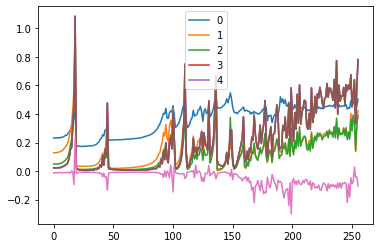

In [45]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

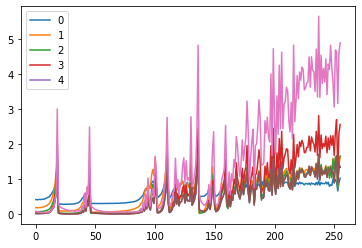

In [46]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

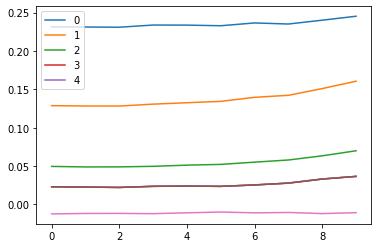

In [47]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

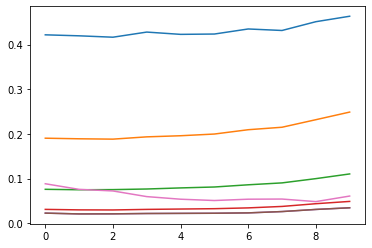

In [48]:
for l in model.act_stds: plt.plot(l[:10])

In [49]:
model = get_cnn_model(data, nfs)
learn, run = get_learn_runner(model, data, 0.5, cbfs)

In [50]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [51]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [52]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [53]:
run.fit(1, learn)

train: [1.8709096354166668, tensor(0.3286, device='cuda:0')]
valid: [1.1002435546875, tensor(0.6316, device='cuda:0')]


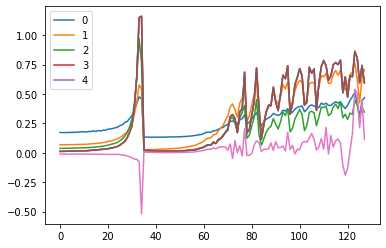

In [54]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hook class

In [55]:
def children(m): return list(m.children())

In [56]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def __del__(self): self.remove()
    def remove(self): self.hook.remove()

In [57]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [58]:
model = get_cnn_model(data, nfs)
learn, run = get_learn_runner(model, data, 0.5, cbfs)

In [59]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [60]:
run.fit(1, learn)

train: [1.4790875, tensor(0.4961, device='cuda:0')]
valid: [0.63740361328125, tensor(0.8059, device='cuda:0')]


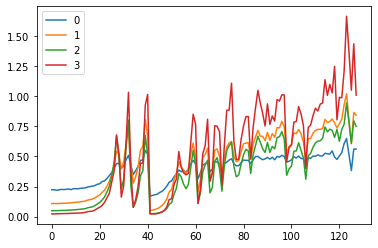

In [61]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

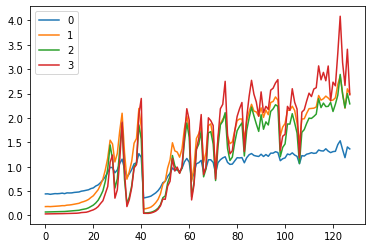

In [62]:
for h in hooks:
    plt.plot(h.stats[1])
    h.remove()
plt.legend(range(4));

# A hooks class

In [70]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self)
            return [o for o,m in zip(self.items, idx) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = 0
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: res = res[:-1] + "...]"
        return res

In [71]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [72]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [73]:
t = ListContainer(range(10))
t[[1,2]], t[[False] * 8 + [True, False]]

([1, 2], [8])

In [74]:
from torch.nn import init

In [75]:
class Hooks(ListContainer):
    def __init__(self, model, f): super().__init__([Hook(layer, f) for layer in model])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for hook in self: hook.remove()

In [106]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_learn_runner(model, data, 0.9, cbfs)

In [107]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f3e61dac7f0>, <__main__.Hook object at 0x7f3e61ec8610>, <__main__.Hook object at 0x7f3e6ca9d880>, <__main__.Hook object at 0x7f3e6e3c88b0>, <__main__.Hook object at 0x7f3e611542e0>, <__main__.Hook object at 0x7f3e61154e20>, <__main__.Hook object at 0x7f3e61154c10>]

In [108]:
hooks.remove()

In [109]:
x, y = next(iter(data.train_dl))
x = mnist_view(x).cuda()

In [110]:
x.mean(), x.std()

(tensor(0.0108, device='cuda:0'), tensor(1.0117, device='cuda:0'))

In [103]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2093, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4840, device='cuda:0', grad_fn=<StdBackward0>))

In [111]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [94]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4145, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8031, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.7248044270833334, tensor(0.3982, device='cuda:0')]
valid: [1.58960703125, tensor(0.5806, device='cuda:0')]
train: [0.34505029296875, tensor(0.8909, device='cuda:0')]
valid: [0.2108739013671875, tensor(0.9311, device='cuda:0')]


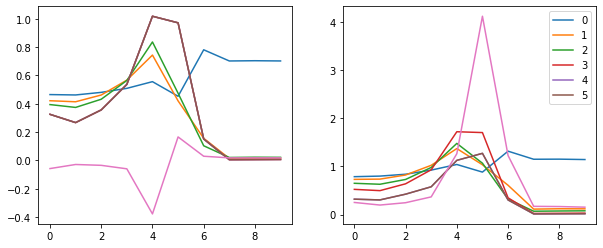

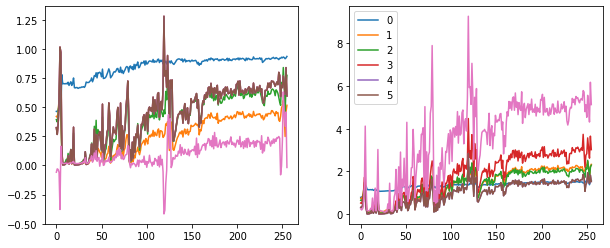

In [112]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
        
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [113]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))

In [117]:
model = get_cnn_model(data, nfs)
learn, run = get_learn_runner(model, data, 0.6, cbfs)

In [118]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [119]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.2382526041666666, tensor(0.5901, device='cuda:0')]
valid: [0.2555456298828125, tensor(0.9259, device='cuda:0')]


In [120]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

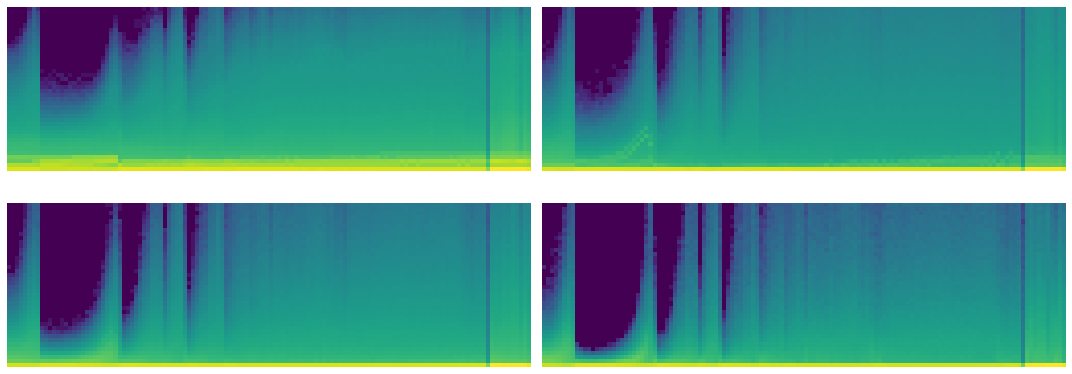

In [121]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax , h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [122]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0) / h1.sum(0)

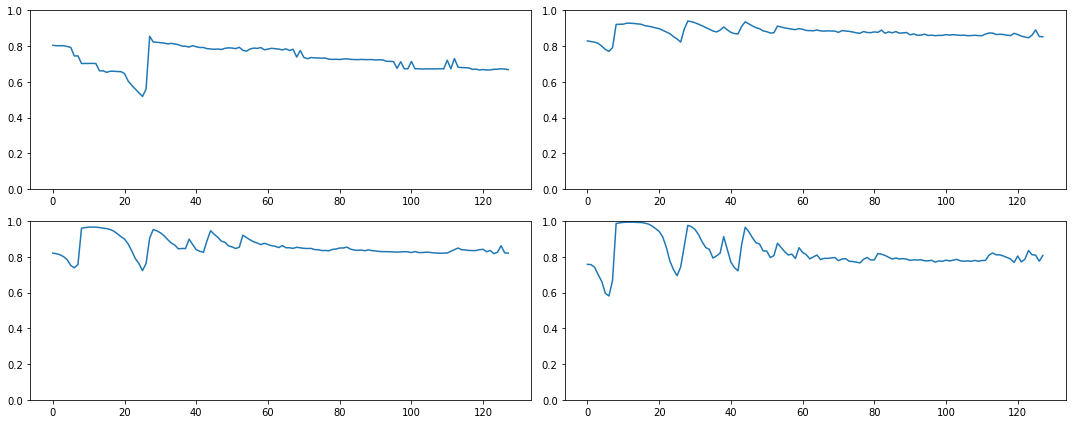

In [124]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Generalized ReLU

In [125]:
get_cnn_model??

Signature: get_cnn_model(data, nfs)
Docstring: <no docstring>
Source:   
def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))
File:      /tmp/ipykernel_1789/468139634.py
Type:      function


In [154]:
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer))

In [155]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i == 0 else 3, **kwargs) for i in range(len(nfs) - 1)] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

In [156]:
def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, stride, padding=ks//2), GeneralRelu(**kwargs))

In [157]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [161]:
def init_cnn(model, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for layer in model:
        if isinstance(layer, nn.Sequential):
            f(layer[0].weight, a=0.1)
            layer[0].bias.data.zero_()

In [162]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [284]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=.4, maxv=6.)
init_cnn(model)
learn, run = get_learn_runner(model, data, 0.9, cbfs)

TypeError: get_learn_runner() missing 1 required positional argument: 'layer'

train: [1.0840252604166667, tensor(0.6523, device='cuda:0')]
valid: [0.27403447265625, tensor(0.9089, device='cuda:0')]


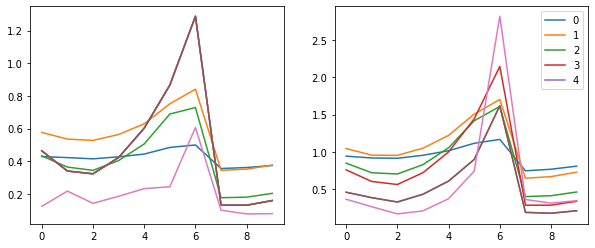

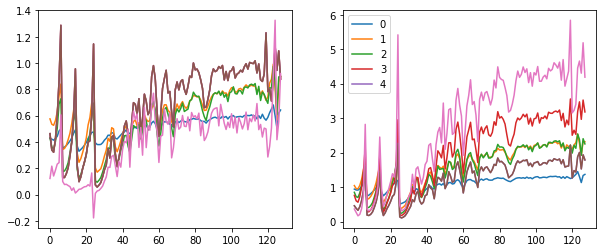

In [272]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, _ = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, _ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

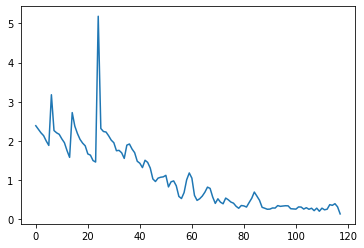

In [273]:
run.recorder.plot_loss()

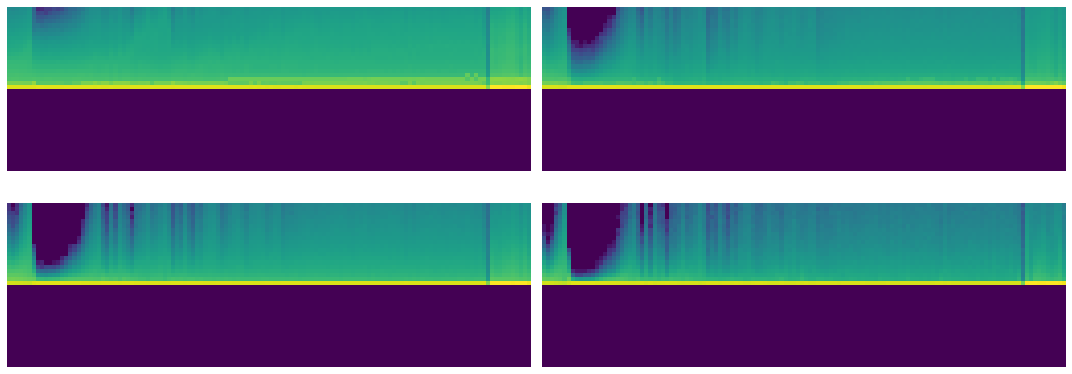

In [259]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [260]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0) / h1.sum(0)

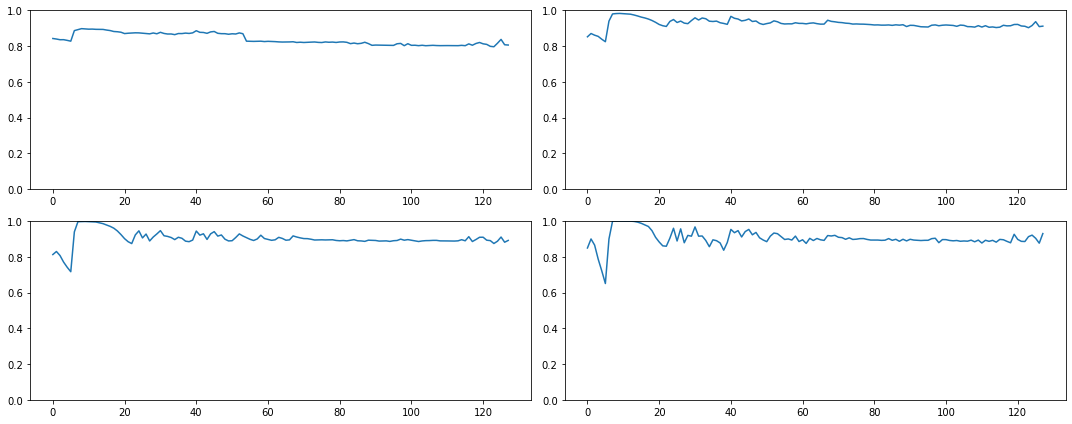

In [261]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [274]:
get_learn_runner??

Signature:
get_learn_runner(
    model,
    data,
    lr=0.6,
    cbs=None,
    opt_func=None,
    loss_func=<function cross_entropy at 0x7f3ea6dc8280>,
)
Docstring: <no docstring>
Source:   
def get_learn_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    
    return learn, Runner(cb_funcs=listify(cbs))
File:      /tmp/ipykernel_1789/3098495768.py
Type:      function


In [315]:
def get_learn_runner(nfs, data, lr, layer, cbs=None, opt_func=None, loss_func=F.cross_entropy, uniform=False, **kwargs):
    if opt_func is None: opt_func = optim.SGD
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    
    return learn, Runner(cb_funcs=listify(cbs))

In [316]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [317]:
learn, run = get_learn_runner(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [318]:
run.fit(8, learn)

train: [1.0493574869791666, tensor(0.6737, device='cuda:0')]
valid: [1.3596861328125, tensor(0.5586, device='cuda:0')]
train: [0.2974433268229167, tensor(0.9099, device='cuda:0')]
valid: [0.2953871826171875, tensor(0.9048, device='cuda:0')]
train: [0.18979026692708334, tensor(0.9430, device='cuda:0')]
valid: [0.1075738525390625, tensor(0.9652, device='cuda:0')]
train: [0.241871923828125, tensor(0.9283, device='cuda:0')]
valid: [0.18091199951171874, tensor(0.9435, device='cuda:0')]
train: [0.0886078125, tensor(0.9726, device='cuda:0')]
valid: [0.10837247314453125, tensor(0.9671, device='cuda:0')]
train: [0.05788561197916667, tensor(0.9823, device='cuda:0')]
valid: [0.08713517456054687, tensor(0.9727, device='cuda:0')]
train: [0.04370059814453125, tensor(0.9866, device='cuda:0')]
valid: [0.055032318115234374, tensor(0.9827, device='cuda:0')]
train: [0.03565559488932292, tensor(0.9893, device='cuda:0')]
valid: [0.04939246215820312, tensor(0.9838, device='cuda:0')]


In [319]:
learn, run = get_learn_runner(nfs, data, 1., conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)], uniform=True)

In [320]:
run.fit(8, learn)

train: [0.8300489583333334, tensor(0.7329, device='cuda:0')]
valid: [1.367886328125, tensor(0.6735, device='cuda:0')]
train: [0.36978512369791666, tensor(0.8905, device='cuda:0')]
valid: [0.1687711181640625, tensor(0.9466, device='cuda:0')]
train: [0.19306066080729167, tensor(0.9411, device='cuda:0')]
valid: [0.199126171875, tensor(0.9378, device='cuda:0')]
train: [0.11554440104166666, tensor(0.9643, device='cuda:0')]
valid: [0.8709869140625, tensor(0.7838, device='cuda:0')]
train: [0.5503826171875, tensor(0.8351, device='cuda:0')]
valid: [0.161262841796875, tensor(0.9511, device='cuda:0')]
train: [0.10923776041666666, tensor(0.9664, device='cuda:0')]
valid: [0.1261471923828125, tensor(0.9590, device='cuda:0')]
train: [0.0772339599609375, tensor(0.9758, device='cuda:0')]
valid: [0.08036375122070312, tensor(0.9733, device='cuda:0')]
train: [0.06413870035807291, tensor(0.9805, device='cuda:0')]
valid: [0.069174609375, tensor(0.9761, device='cuda:0')]


In [345]:
learn, run = get_learn_runner(nfs, data, 0.3, conv_layer, cbs=cbfs, leak=0.1, sub=0.4, maxv=6.)

train: [0.9719900390625, tensor(0.6941, device='cuda:0')]
valid: [0.2547102783203125, tensor(0.9214, device='cuda:0')]


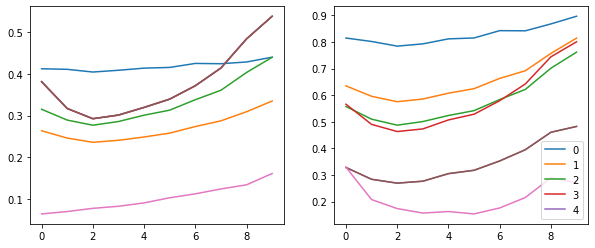

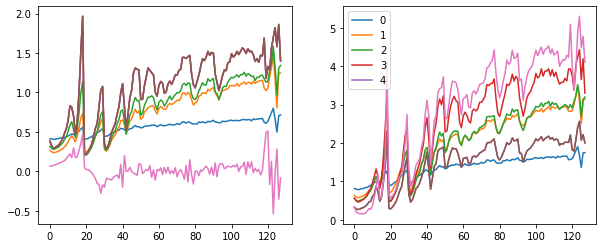

In [346]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, _ = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms, ss, _ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

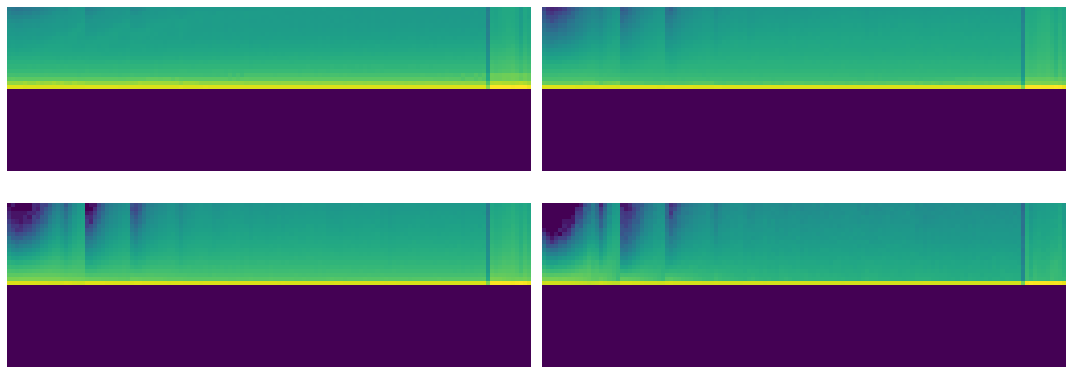

In [347]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

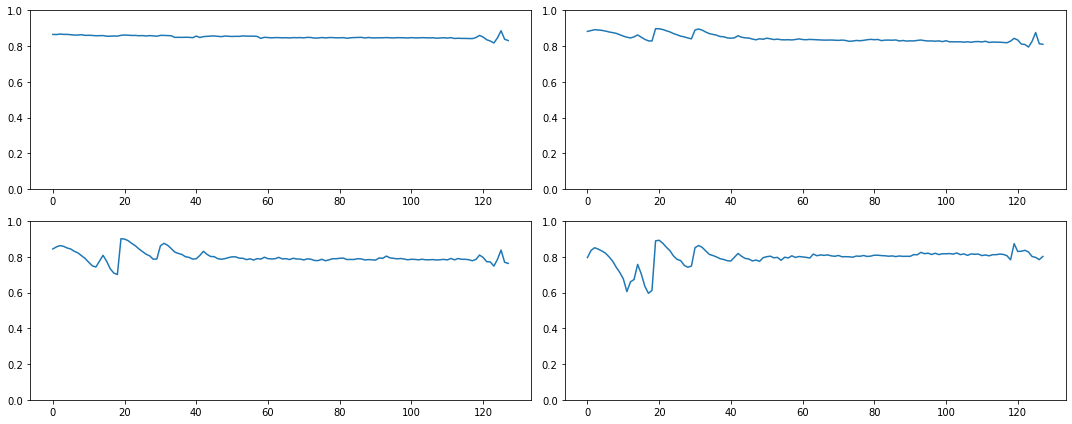

In [348]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()